## LTEE-FBA-Jenga.ipynb by Rohan Maddamsetti

See documentation at: 
https://cobrapy.readthedocs.io/en/latest/  

In [3]:
import matplotlib as plt
import cobra.test
import cobra
import pandas as pd
import numpy as np
from scipy import stats
from os import path
import random
from plotnine import *

In [4]:
## use Gurobi. Necessary for constructing minimal genomes!
cobra_config = cobra.Configuration()
cobra_config.solver = "gurobi"
cobra_config

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-1000.0
upper_bound,Default reaction upper bound,1000.0
processes,Number of parallel processes,3
cache_directory,Path for the model cache,/Users/Rohandinho/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Functions.

In [5]:
def make_dict_of_KO_strains(anc_model, gene_vec=[]):
    deletion_cobra_models = {}
    
    gene_str_list = [str(gene_obj) for gene_obj in anc_model.genes]
    if len(gene_vec): ## then filter for the genes (strings) in gene_vec.
        gene_str_list = [x for x in gene_str_list if x in gene_vec]
        
    for genestr in gene_str_list:
        cur_KO_model = anc_model.copy()
        cur_KO_model.id = '_'.join([anc_model.id, genestr, "knockout"])
        cur_gene = cur_KO_model.genes.get_by_id(genestr)
        cobra.manipulation.delete_model_genes(cur_KO_model, cur_gene)
        deletion_cobra_models[genestr] = cur_KO_model
    return deletion_cobra_models

In [6]:
def generate_LTEE_clone_cobra_models(KOed_genes_df, basic_model, using_locus_tag=False):
    
    LTEE_cobra_models = {}
    nonmutator_pops = ["Ara-5", "Ara-6", "Ara+1", "Ara+2", "Ara+4", "Ara+5"]
    mutator_pops = ["Ara-1", "Ara-2", "Ara-3", "Ara-4", "Ara+3", "Ara+6"]
    LTEE_pop_vec = nonmutator_pops + mutator_pops
    model_genes = [x.id for x in basic_model.genes]
    
    for LTEE_pop in LTEE_pop_vec:
        cur_KO_model = basic_model.copy()
        cur_KO_model.id = LTEE_pop + "_50K_A_clone"
        is_cur_pop = (KOed_genes_df["Population"] == LTEE_pop)
        
        if using_locus_tag:
            KOed_genes = [x for x in KOed_genes_df[is_cur_pop].locus_tag]
        else:
            KOed_genes = [x for x in KOed_genes_df[is_cur_pop].blattner]
        
        genes_to_remove = [cur_KO_model.genes.get_by_id(x) for x in KOed_genes if x in model_genes]
        if genes_to_remove:
            cobra.manipulation.delete_model_genes(cur_KO_model, genes_to_remove)
        
        LTEE_cobra_models[LTEE_pop] = cur_KO_model
    
    return LTEE_cobra_models

## Basic metabolic models to play with. Default objective is to maximize biomass.

In [7]:
BiGG_model_dir = "../data/BiGG-models"

# the E. coli K-12 iJO1366 model: this is the best curated complete E. coli model.
K12_model = cobra.io.load_json_model(path.join(BiGG_model_dir, "iJO1366.json"))
K12_model.id = "K12"

# the E. coli REL606 iECB_1328 model: most relevant to LTEE, but has stochiometric inconsistencies
## in hydrogen/proton conservation.
REL606_model = cobra.io.load_json_model(path.join(BiGG_model_dir, "iECB_1328.json"))
REL606_model.id = "REL606"

## The simplest well-curated model: E. coli core metabolism.
core_model = cobra.io.load_json_model(path.join(BiGG_model_dir, "e_coli_core.json"))
core_model.id = "Ecoli-core"

Set parameter Username
Academic license - for non-commercial use only - expires 2022-12-16


In [8]:
## we are simulating media in which glucose import is limiting.
## Add an excess of thiamine to simulate DM25.
K12_medium = K12_model.medium
K12_medium['EX_thm_e'] = 1000.0
K12_model.medium = K12_medium
REL606_medium = REL606_model.medium
REL606_medium['EX_thm_e'] = 1000.0
REL606_model.medium = REL606_medium

print(K12_model.medium)
print(REL606_model.medium)
print(core_model.medium)

{'EX_co2_e': 1000.0, 'EX_cobalt2_e': 1000.0, 'EX_glc__D_e': 10.0, 'EX_h_e': 1000.0, 'EX_h2o_e': 1000.0, 'EX_k_e': 1000.0, 'EX_cu2_e': 1000.0, 'EX_mg2_e': 1000.0, 'EX_mn2_e': 1000.0, 'EX_mobd_e': 1000.0, 'EX_na1_e': 1000.0, 'EX_nh4_e': 1000.0, 'EX_ca2_e': 1000.0, 'EX_cbl1_e': 0.01, 'EX_ni2_e': 1000.0, 'EX_o2_e': 1000.0, 'EX_cl_e': 1000.0, 'EX_pi_e': 1000.0, 'EX_zn2_e': 1000.0, 'EX_sel_e': 1000.0, 'EX_slnt_e': 1000.0, 'EX_so4_e': 1000.0, 'EX_thm_e': 1000.0, 'EX_tungs_e': 1000.0, 'EX_fe2_e': 1000.0, 'EX_fe3_e': 1000.0}
{'EX_ca2_e': 1000.0, 'EX_cbl1_e': 0.01, 'EX_cl_e': 1000.0, 'EX_co2_e': 1000.0, 'EX_cobalt2_e': 1000.0, 'EX_cu2_e': 1000.0, 'EX_fe2_e': 1000.0, 'EX_fe3_e': 1000.0, 'EX_mg2_e': 1000.0, 'EX_mn2_e': 1000.0, 'EX_mobd_e': 1000.0, 'EX_na1_e': 1000.0, 'EX_nh4_e': 1000.0, 'EX_ni2_e': 1000.0, 'EX_glc__D_e': 10.0, 'EX_o2_e': 1000.0, 'EX_tungs_e': 1000.0, 'EX_pi_e': 1000.0, 'EX_zn2_e': 1000.0, 'EX_sel_e': 1000.0, 'EX_slnt_e': 1000.0, 'EX_so4_e': 1000.0, 'EX_thm_e': 1000.0, 'EX_h_e': 10

In [9]:
 for rxn in REL606_model.reactions:
        if rxn.functional:
            ## important: print rxn.id, not rxn.                            
            print(rxn.id)

EX_all__D_e
EX_alltn_e
EX_anhgm_e
EX_ala__L_e
EX_amp_e
EX_alaala_e
EX_arab__L_e
EX_arbtn_e
EX_arbt_e
EX_arg__L_e
EX_arbtn_fe3_e
EX_asn__L_e
EX_ascb__L_e
EX_g3ps_e
EX_aso3_e
EX_asp__L_e
EX_btn_e
EX_but_e
EX_acmum_e
DM_4crsol_c
DM_5drib_c
DM_aacald_c
EX_butso3_e
EX_ca2_e
DM_amob_c
EX_cbi_e
DM_mththf_c
EX_g6p_e
DM_oxam_c
BIOMASS_Ec_iJO1366_WT_53p95M
EX_cbl1_e
EX_cd2_e
EX_cgly_e
BIOMASS_Ec_iJO1366_core_53p95M
EX_12ppd__R_e
EX_12ppd__S_e
EX_14glucan_e
EX_15dap_e
EX_23camp_e
EX_23ccmp_e
EX_23cgmp_e
EX_23cump_e
EX_23dappa_e
EX_chol_e
EX_chtbs_e
EX_cit_e
EX_cl_e
EX_cm_e
EX_cmp_e
EX_co2_e
EX_cobalt2_e
EX_colipa_e
EX_colipap_e
EX_26dap__M_e
EX_2ddglcn_e
EX_34dhpac_e
EX_cpgn_e
EX_3amp_e
EX_gal_e
EX_3cmp_e
EX_3gmp_e
EX_3hcinnm_e
EX_cpgn_un_e
EX_crn_e
EX_crn__D_e
EX_csn_e
EX_3hpp_e
EX_gal_bD_e
EX_3hpppn_e
EX_cu_e
EX_cu2_e
EX_3ump_e
EX_4abut_e
EX_4hoxpacd_e
EX_cyan_e
EX_cynt_e
EX_cys__D_e
EX_cys__L_e
EX_5dglcn_e
EX_5mtr_e
EX_LalaDglu_e
EX_cytd_e
EX_dad_2_e
EX_LalaDgluMdap_e
EX_damp_e
EX_gal1p_e
EX_d

FEOXAMtonex
FEROpp
DHBS
FESD1s
FESD2s
FECRMUtex
FECRMUtpp
FECRMabcpp
FECRMexs
FESR
FHL
FLDR2
FLVR
DHBSH
FLVRx
FMETTRS
FMNAT
FUMtex
FUSAtex
FUSAtpp
G1PACT
FMNRx
FMNRx2
G1PPpp
G1PTT
FOMETRi
DHCIND
FORCT
G1Ptex
G1SAT
G2PP
G2PPpp
FORt2pp
FORtex
G3PAT120
G3PAT140
FORtppi
DHCINDO
FRD2
FRD3
FRUK
FRULYSDG
FRULYSE
FRULYSK
G3PAT141
G3PAT160
G3PAT161
G3PAT180
G3PAT181
G3PCabcpp
FRULYSt2pp
FRULYStex
FRUURt2rpp
FRUURtex
G3PCtex
G3PD2
FRUpts2pp
DHDPRy
FRUptspp
FRUtex
G3PD5
G3PD6
G3PD7
G3PEabcpp
FTHFD
FTHFLi
DHDPS
FUCtex
FUM
FUMt2_2pp
G3PEtex
G3PGabcpp
G3PGtex
G3PIabcpp
FUMt2_3pp
DHFR
GALKr
G3PItex
G3PSabcpp
G3PStex
GALM2pp
DHFS
GALS3
G3PT
G5SADs
G5SD
GALTptspp
G6PDA
GALTtex
DHMPTR
GALURt2rpp
G6PDH2r
G6PP
G6Pt6_2pp
GALURtex
GALUi
GALabcpp
GALt2pp
GALtex
G6Ptex
GAL1PPpp
GAL1Ptex
GALBDtex
GAM6Pt6_2pp
GALCTD
GAMAN6Ptex
DHNAOT4
GAMptspp
GAMtex
GAPD
GALCTLO
GALCTND
GALCTNLt2pp
GALCTNLtex
GALCTNt2pp
GARFT
GART
GALCTNtex
GBBTNtex
DHNCOAS
GALCTt2rpp
GALCTtex
GCALDD
DHNCOAT
GDMANE
GDPDPK
GDPMNH
GDPMNP
GDPTPDP

ThDPAT
U23GAAT
UAAGDS
UACGALPpp
UACGAMPpp
UACGAMtex
UACMAMO
UAG2E
UAGAAT
UAGCVT
UAGDP
TMPPP
TPI
TPRDCOAS
TRDR
TRE6PH
TRE6PP
TRE6PS
UAGPT3
UAMAGS
UAMAS
TREH
TREHpp
UM4PCP
TREptspp
TREtex
TRPAS2
TRPS1
TRPS2
TRPS3
TRPTRS
TRPt2rpp
TRPtex
UAPGR
UDCPDP
UDCPDPS
UDCPDPpp
UDCPPtppi
UDPACGALtex
UDPG4E
UDPGALPpp
UDPGALtex
UDPGD
UDPGDC
UDPGLCURtex
UDPGPpp
UDPGtex
UDPKAAT
UM3PL
UM4PL
UGLCURPpp
UGLT
UGLYCH
DHEDAA
UMPK
UGMDDS
UHGADA
ULA4NFT
ULA4Ntppi
HACD3i
UMPtex
4HOXPACt2pp
TARTRtpp
3PGtex
EX_icit_e
UPLA4FNF
OAAtex
EX_pep_e
OCDCEAt2pp
EX_acon_C_e
GLYBt2pp_copy2
TETtex
PSUDS
UPLA4FNT
EX_colipa20Oag_e
BSORx
DHPDO
OPTCCL
SALCHSXtex
UPP3MT
ENTERH
EX_remnant1_e
UPP3S
SCYSSL
UNK3
HDCAt2pp
EX_udcpo5_e
EX_chitob_e
UPPDC1
TAG1PK
HACD2i
EX_feroxB_e
EX_tcb_e
EX_tton_e
NMNR
PUNP7
ACONCtex
DXYLUDtpp
ADOCBLPS
ADOCBLPP
EX_salchs2_e
DSCLCOCH
AIRStex
EX_4hthr_e
HPA3MO
DXYLUDtex
CHITOBpts
UPPRT
EX_feroxEfe_e
AIRStpp
EX_feroxE_e
CTECOAI8_copy2
URACPAH
HACD1i
SLCYSS
4HTHRK
HACD5i
EX_rnam_e
URAt2pp_copy1
4HOXPACMOF
EX_

In [10]:
nonmutator_pops = ["Ara-5", "Ara-6", "Ara+1", "Ara+2", "Ara+4", "Ara+5"]
mutator_pops = ["Ara-1", "Ara-2", "Ara-3", "Ara-4", "Ara+3", "Ara+6"]
LTEE_pop_vec = nonmutator_pops + mutator_pops

## Question 2: Measure fitness of 50K A clones using the whole genome metabolic model.

In [11]:
inactive_genes_in_50K_A_clones = pd.read_csv(
    "../results/metabolic-enzymes/inactive-genes-in-LTEE-50K-A-clones.csv",)
inactive_genes_in_50K_A_clones

,Population,locus_tag,Gene,blattner,gene_length,product,start,end,strand
0,Ara-1,ECB_00100,mutT,b0099,390,nucleoside triphosphate pyrophosphohydrolase m...,113848,114237,1
1,Ara-1,ECB_00259,ykgI,b0303,237,hypothetical protein,290980,291216,-1
2,Ara-1,ECB_00320,ECB_00320,b0370,198,hypothetical protein,358825,359022,-1
3,Ara-1,ECB_00429,ybaL,b0478,1677,predicted transporter with NADP-binding Rossma...,473629,475305,-1
4,Ara-1,ECB_00460,ybbV,b0510,279,hypothetical protein,509662,509940,1
...,...,...,...,...,...,...,...,...,...
2175,Ara+5,ECB_03938,yjcF,b4066,1293,hypothetical protein,4260716,4262008,-1
2176,Ara+5,ECB_04094,yzfA,b4223,183,hypothetical protein,4431733,4431915,-1
2177,Ara+5,ECB_04101,mpl,b4233,1374,UDP-N-acetylmuramate:L-alanyl-gamma-D-glutamyl...,4439035,4440408,1
2178,Ara+5,ECB_04123,yjgN,b4257,1197,conserved inner membrane protein,4462763,4463959,1


In [12]:
## Generate models from K-12.
iJO1366_LTEE_models = generate_LTEE_clone_cobra_models(inactive_genes_in_50K_A_clones, K12_model)
## Generate models from REL606.
iECB_1328_LTEE_models = generate_LTEE_clone_cobra_models(inactive_genes_in_50K_A_clones, REL606_model, using_locus_tag=True)

Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmprroocyo6.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmpxept5f3t.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmpg_knvybx.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmp94z4oyvt.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmpnx1rq9d1.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmp2j82o3dw.lp
Reading time = 0.02 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP fo

## Cross-check the list of essential genes in the K12 and REL606 models with inactive genes in the 50K LTEE clones.

In [13]:
K12_essential_genes = [str(x) for x in cobra.flux_analysis.find_essential_genes(K12_model)]
REL606_essential_genes = [str(x) for x in cobra.flux_analysis.find_essential_genes(REL606_model)]

In [14]:
print(K12_essential_genes)
print(len(K12_essential_genes))
print()
print(REL606_essential_genes)
print(len(REL606_essential_genes))

['b3730', 'b3642', 'b3041', 'b3256', 'b0096', 'b0778', 'b1277', 'b3040', 'b3255', 'b4214', 'b2750', 'b0750', 'b3368', 'b2478', 'b0908', 'b1131', 'b1662', 'b4160', 'b0415', 'b2315', 'b3939', 'b0386', 'b1288', 'b1208', 'b4177', 'b2585', 'b2020', 'b2022', 'b3433', 'b0134', 'b2687', 'b3804', 'b0009', 'b2751', 'b1069', 'b3997', 'b0475', 's0001', 'b3634', 'b2752', 'b0154', 'b3058', 'b0785', 'b0826', 'b2599', 'b2600', 'b0524', 'b2329', 'b1098', 'b0133', 'b4039', 'b3805', 'b2472', 'b0087', 'b0914', 'b3941', 'b0086', 'b1062', 'b2762', 'b3177', 'b3648', 'b0783', 'b4040', 'b3607', 'b3960', 'b0784', 'b3187', 'b0781', 'b3771', 'b3018', 'b3389', 'b3958', 'b0907', 'b3172', 'b0131', 'b1281', 'b3633', 'b1693', 'b0052', 'b0421', 'b3608', 'b0182', 'b0142', 'b4006', 'b3959', 'b2818', 'b0029', 'b2564', 'b0003', 'b0522', 'b4013', 'b3843', 'b4245', 'b0523', 'b2311', 'b2312', 'b0173', 'b0185', 'b2320', 'b2021', 'b0420', 'b3967', 'b0031', 'b2316', 'b3359', 'b2574', 'b4262', 'b0915', 'b3412', 'b3200', 'b1210', 

In [15]:
inactive_genes_in_50K_A_clones[inactive_genes_in_50K_A_clones.blattner.isin(K12_essential_genes)]

,Population,locus_tag,Gene,blattner,gene_length,product,start,end,strand
432,Ara-3,ECB_01370,aldA,b1415,1440,aldehyde dehydrogenase A NAD-linked,1457563,1459002,1
800,Ara-4,ECB_01094,tmk,b1098,642,thymidylate kinase,1169693,1170334,1
1106,Ara-5,ECB_02596,ispF,b2746,480,2-C-methyl-D-erythritol 24-cyclodiphosphate sy...,2766162,2766641,-1
1597,Ara+2,ECB_02597,ispD,b2747,711,2-C-methyl-D-erythritol 4-phosphate cytidylylt...,2766641,2767351,-1


In [16]:
inactive_genes_in_50K_A_clones[inactive_genes_in_50K_A_clones.locus_tag.isin(REL606_essential_genes)]

,Population,locus_tag,Gene,blattner,gene_length,product,start,end,strand
432,Ara-3,ECB_01370,aldA,b1415,1440,aldehyde dehydrogenase A NAD-linked,1457563,1459002,1
800,Ara-4,ECB_01094,tmk,b1098,642,thymidylate kinase,1169693,1170334,1
1106,Ara-5,ECB_02596,ispF,b2746,480,2-C-methyl-D-erythritol 24-cyclodiphosphate sy...,2766162,2766641,-1
1558,Ara+2,ECB_02356,tktB,b2465,2004,transketolase 2 thiamin-binding,2500464,2502467,1
1597,Ara+2,ECB_02597,ispD,b2747,711,2-C-methyl-D-erythritol 4-phosphate cytidylylt...,2766641,2767351,-1


## generate an input file for STIMS to see if there is purifying selection in the LTEE on essential genes in the REL606 model in minimal glucose. There is! This is a really nice result.

In [17]:
REL606_ids = pd.read_csv("../results/REL606_IDs.csv")
glucose_essential = REL606_ids[REL606_ids.locus_tag.isin(REL606_essential_genes)]
glucose_essential.to_csv("../results/metabolic-enzymes/glucose_FBA_essential.csv",sep=",")

## generate an input file for STIMS to see if there is purifying selection in Ara-3 on essential genes in the REL606 model in minimal citrate.

In [18]:
citrate_model = REL606_model.copy()

citrate_medium = REL606_model.medium
citrate_medium['EX_glc__D_e'] = 0.0 ## no glucose
citrate_medium['EX_cit_e'] = 100.0
citrate_model.medium = citrate_medium

citrate_essential_genes = [str(x) for x in cobra.flux_analysis.find_essential_genes(citrate_model)]
citrate_essential = REL606_ids[REL606_ids.locus_tag.isin(citrate_essential_genes)]
citrate_essential.to_csv("../results/metabolic-enzymes/citrate_FBA_essential.csv",sep=",")
print(citrate_essential)

Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmp4dxlkc2i.lp
Reading time = 0.02 seconds
: 1951 rows, 5496 columns, 21258 nonzeros
      Gene  locus_tag blattner  gene_length  \
2     thrB  ECB_00003    b0003          933   
3     thrC  ECB_00004    b0004         1287   
8     mogA  ECB_00009    b0009          588   
24    ribF  ECB_00029    b0025          942   
28    ispH  ECB_00033    b0029          951   
...    ...        ...      ...          ...   
3942  cysQ  ECB_04086    b4214          741   
3968  pyrB  ECB_04113    b4245          936   
3975  argI  ECB_04120    b4254         1005   
3982  yjgP  ECB_04127    b4261         1101   
3983  yjgQ  ECB_04128    b4262         1083   

                                                product    start      end  \
2                                     homoserine kinase     2800     3732   
3                                    threonine synthase     3733     5019   
8              molybdenum cofactor bios

In [19]:
## compare the sets of genes that are essential on glucose versus those essential on citrate.
citrate_essential_set = set(citrate_essential.Gene)
glucose_essential_set = set(glucose_essential.Gene)
print(citrate_essential_set - glucose_essential_set)
print()
print(glucose_essential_set - citrate_essential_set)

{'gapA', 'pgk', 'citT', 'tpiA'}

{'gltA'}


## generate an input file for STIMS to see if there is purifying selection in Ara-3 on essential genes in the REL606 model in minimal acetate.

In [20]:
acetate_model = REL606_model.copy()

acetate_medium = REL606_model.medium
acetate_medium['EX_glc__D_e'] = 0.0 ## no glucose
acetate_medium['EX_ac_e'] = 10.0
acetate_model.medium = acetate_medium

acetate_essential_genes = [str(x) for x in cobra.flux_analysis.find_essential_genes(acetate_model)]
acetate_essential = REL606_ids[REL606_ids.locus_tag.isin(acetate_essential_genes)]
acetate_essential.to_csv("../results/metabolic-enzymes/acetate_FBA_essential.csv",sep=",")
print(acetate_essential)

Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmptat00hpo.lp
Reading time = 0.02 seconds
: 1951 rows, 5496 columns, 21258 nonzeros
      Gene  locus_tag blattner  gene_length  \
2     thrB  ECB_00003    b0003          933   
3     thrC  ECB_00004    b0004         1287   
8     mogA  ECB_00009    b0009          588   
24    ribF  ECB_00029    b0025          942   
28    ispH  ECB_00033    b0029          951   
...    ...        ...      ...          ...   
3942  cysQ  ECB_04086    b4214          741   
3968  pyrB  ECB_04113    b4245          936   
3975  argI  ECB_04120    b4254         1005   
3982  yjgP  ECB_04127    b4261         1101   
3983  yjgQ  ECB_04128    b4262         1083   

                                                product    start      end  \
2                                     homoserine kinase     2800     3732   
3                                    threonine synthase     3733     5019   
8              molybdenum cofactor bios

In [21]:
## compare the sets of genes that are essential on glucose versus those essential on acetate.
acetate_essential_set = set(acetate_essential.Gene)
glucose_essential_set = set(glucose_essential.Gene)
print(acetate_essential_set - glucose_essential_set)
print()
print(glucose_essential_set - acetate_essential_set)

{'gapA', 'atpC', 'atpF', 'tpiA', 'atpB', 'atpA', 'pgk', 'atpE', 'atpG', 'atpD', 'atpH'}

set()


## generate an input file for STIMS to see if there is purifying selection in Ara-3 on essential genes in the REL606 model in minimal glucose + acetate.

In [36]:
glucose_acetate_model = REL606_model.copy()

glucose_acetate_medium = REL606_model.medium
glucose_acetate_medium['EX_ac_e'] = 1.0 ##10.0 ## keep glucose, add acetate
glucose_acetate_model.medium = glucose_acetate_medium

glucose_acetate_essential_genes = [str(x) for x in cobra.flux_analysis.find_essential_genes(glucose_acetate_model)]
glucose_acetate_essential = REL606_ids[REL606_ids.locus_tag.isin(citrate_essential_genes)]
glucose_acetate_essential.to_csv("../results/metabolic-enzymes/glucose_acetate_FBA_essential.csv",sep=",")
print(glucose_acetate_essential)

Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmp0h8jn_lr.lp
Reading time = 0.02 seconds
: 1951 rows, 5496 columns, 21258 nonzeros
      Gene  locus_tag blattner  gene_length  \
2     thrB  ECB_00003    b0003          933   
3     thrC  ECB_00004    b0004         1287   
8     mogA  ECB_00009    b0009          588   
24    ribF  ECB_00029    b0025          942   
28    ispH  ECB_00033    b0029          951   
30    dapB  ECB_00035    b0031          822   
50    pdxA  ECB_00056    b0052          990   
67    leuD  ECB_00073    b0071          606   
68    leuC  ECB_00074    b0072         1401   
69    leuB  ECB_00075    b0073         1092   
70    leuA  ECB_00076    b0074         1572   
80    murE  ECB_00086    b0085         1488   
81    murF  ECB_00087    b0086         1359   
82    mraY  ECB_00088    b0087         1083   
83    murD  ECB_00089    b0088         1317   
85    murG  ECB_00091    b0090         1068   
86    murC  ECB_00092    b0091      

In [37]:
## compare the sets of genes that are essential on glucose versus those essential on glucose+acetate,
## and the sets of genes that are essential on acetate versus those essential on glucose+acetate.
acetate_essential_set = set(acetate_essential.Gene)
glucose_essential_set = set(glucose_essential.Gene)
glucose_acetate_essential_set = set(glucose_acetate_essential.Gene)
print(acetate_essential_set - glucose_acetate_essential_set)
print()
print(glucose_acetate_essential_set - acetate_essential_set)
print()
print()
print(glucose_essential_set - glucose_acetate_essential_set)
print()
print(glucose_acetate_essential_set - glucose_essential_set)

{'atpC', 'atpF', 'atpB', 'atpA', 'gltA', 'atpE', 'atpG', 'atpD', 'atpH'}

{'citT'}


{'gltA'}

{'gapA', 'pgk', 'citT', 'tpiA'}


In [38]:
print(citrate_essential_set - glucose_acetate_essential_set)
print()
print(glucose_acetate_essential_set - citrate_essential_set)

set()

set()


## Analyze essential genes in the LTEE 50K metabolic networks.

#### Jenga hypothesis predicts that evolved LTEE 50K metabolic networks should show variation in metabolic essentiality.
- the genes essential across all viable networks are simple the genes essential to the base REL606_model.
- make a table of the genes essential in particular genomes, but not overall. This result is small enough that it doesn't need a figure.

In [23]:
for pop, cur_model in iJO1366_LTEE_models.items():
    print(pop, cur_model.slim_optimize())

Ara-5 0.0
Ara-6 0.9824915382682922
Ara+1 0.9818549149161437
Ara+2 0.0
Ara+4 0.9824915382682928
Ara+5 0.9824765425792205
Ara-1 0.9824915382682908
Ara-2 0.9824915382682917
Ara-3 0.0
Ara-4 0.0
Ara+3 0.9824915382682917
Ara+6 0.9824915382682919


In [24]:
for pop, cur_model in iECB_1328_LTEE_models.items():
    print(pop, cur_model.slim_optimize())

Ara-5 0.0
Ara-6 0.9825981902001607
Ara+1 0.9819614286711661
Ara+2 0.0
Ara+4 0.9825981902001641
Ara+5 0.0
Ara-1 0.9825981902001673
Ara-2 0.9825981902001644
Ara-3 0.0
Ara-4 0.0
Ara+3 0.9825981902001644
Ara+6 0.9825981902001668


In [25]:
LTEEpop_to_essential_genes = {pop:[str(x) for x in cobra.flux_analysis.find_essential_genes(cur_model)] for pop,cur_model in iECB_1328_LTEE_models.items()}

In [26]:
## find the intersection of essential genes in all networks, skipping the nonviable networks for now.
pops_to_examine = [pop for pop in LTEEpop_to_essential_genes.keys() if pop not in ["Ara-5", "Ara+2", "Ara+5",
                                                                                   "Ara-3","Ara-4"]]

essential_intersection = set.intersection(*[set(LTEEpop_to_essential_genes[x]) for x in pops_to_examine])
print(len(essential_intersection))
idiosyncratic_essentials = {x:set(set(LTEEpop_to_essential_genes[x]) - essential_intersection) for x in pops_to_examine}
print(idiosyncratic_essentials)
idiosyncratic_essentials_set = set.union(*[idio_set for _, idio_set in idiosyncratic_essentials.items()])

202
{'Ara-6': {'ECB_01730', 'ECB_03708'}, 'Ara+1': {'ECB_02847', 'ECB_00425', 'ECB_01182', 'ECB_02848', 'ECB_02846', 'ECB_03708'}, 'Ara+4': {'ECB_00070', 'ECB_01102', 'ECB_00069', 'ECB_00068'}, 'Ara-1': {'ECB_01730', 'ECB_01836'}, 'Ara-2': {'ECB_03891', 'ECB_00070', 'ECB_02400', 'ECB_00069', 'ECB_01102', 'ECB_00068'}, 'Ara+3': {'ECB_03555', 'ECB_03554', 'ECB_02400', 'ECB_00002'}, 'Ara+6': set()}


In [27]:
REL606_idiosyncratic_essential = REL606_ids[REL606_ids.locus_tag.isin(idiosyncratic_essentials_set)]
REL606_idiosyncratic_essential

,Gene,locus_tag,blattner,gene_length,product,start,end,strand
1,thrA,ECB_00002,b0002,2463,bifunctional aspartokinase I/homeserine dehydr...,336,2798,1
62,yabJ,ECB_00068,b0066,699,thiamin transporter subunit,75033,75731,-1
63,thiP,ECB_00069,b0067,1611,thiamin ABC transporter membrane protein,75715,77325,-1
64,tbpA,ECB_00070,b0068,984,thiamin transporter subunit,77301,78284,-1
405,adk,ECB_00425,b0474,645,adenylate kinase,469242,469886,1
1059,ycfN,ECB_01102,b1106,825,thiamin kinase,1177829,1178653,1
1134,prsA,ECB_01182,b1207,948,ribose-phosphate pyrophosphokinase,1261078,1262025,-1
1657,gdhA,ECB_01730,b1761,1344,glutamate dehydrogenase,1819599,1820942,1
1762,ntpA,ECB_01836,b1865,453,dATP pyrophosphohydrolase,1926950,1927402,-1
2301,guaB,ECB_02400,b2508,1467,inositol-5-monophosphate dehydrogenase,2553423,2554889,-1


In [28]:
REL606_intersection_essential = REL606_ids[REL606_ids.locus_tag.isin(essential_intersection)]
pd.options.display.max_rows = None
REL606_intersection_essential

,Gene,locus_tag,blattner,gene_length,product,start,end,strand
2,thrB,ECB_00003,b0003,933,homoserine kinase,2800,3732,1
3,thrC,ECB_00004,b0004,1287,threonine synthase,3733,5019,1
8,mogA,ECB_00009,b0009,588,molybdenum cofactor biosynthesis protein,9304,9891,1
24,ribF,ECB_00029,b0025,942,putative regulator,25479,26420,1
28,ispH,ECB_00033,b0029,951,4-hydroxy-3-methylbut-2-enyl diphosphate reduc...,30349,31299,1
30,dapB,ECB_00035,b0031,822,dihydrodipicolinate reductase,32446,33267,1
50,pdxA,ECB_00056,b0052,990,4-hydroxythreonine-4-phosphate dehydrogenase,56622,57611,-1
67,leuD,ECB_00073,b0071,606,isopropylmalate isomerase small subunit,81652,82257,-1
68,leuC,ECB_00074,b0072,1401,isopropylmalate isomerase large subunit,82268,83668,-1
69,leuB,ECB_00075,b0073,1092,3-isopropylmalate dehydrogenase,83671,84762,-1


In [29]:
essential_intersection - set(REL606_essential_genes) ## This is the empty set.

set()

In [30]:
len(set(REL606_essential_genes))

202

## Examine predicted growth across substrates, to parallel Figure 2 in Leiby and Marx (2013).

In [31]:
""" Substrates to (more or less) parallel the substrates in Figure 2 of Leiby and Marx (2013) in PLOS Biology.
glc__D_e D-Glucose
rib__D_e D-Ribose
malt_e Maltose
gal_e D-Galactose
man_e D-Mannose
tre_e Trehalose
lcts_e Lactose
melib_e Melibiose
fru_e D-Fructose
glcn_e D-Gluconate
sbt__D_e D-Sorbitol
ac_e Acetate
lac__L_e L-Lactate
lac__D_e D-Lactate
ser__D_e D-Serine
ser__L_e L-Serine
ala__L_e L-Alanine
ala__D_e D-Alanine
uri_e Uridine
pro__L_e L-Proline
fum_e Fumarate
mal__D_e D-Malate
mal__L_e L-Malate
asp__L_e L-Aspartate
succ_e Succinate
cit_e Citrate
arab__D_e D-Arabinose
arab__L_e L-Arabinose
"""

def generate_viability_profile_df(LTEE_model_dict):
    
    substrates = ["glc__D_e", "rib__D_e", "malt_e", "gal_e", "man_e", "tre_e",
              "lcts_e", "melib_e", "fru_e", "glcn_e", "sbt__D_e", "ac_e", "lac__L_e",
              "lac__D_e", "ser__D_e", "ser__L_e", "ala__L_e", "ala__D_e", "uri_e",
              "pro__L_e", "fum_e", "mal__D_e", "mal__L_e", "asp__L_e", "succ_e",
              "cit_e", "arab__D_e", "arab__L_e"]

    substrate_names = ["D-Glucose", "D-Ribose", "Maltose", "D-Galactose",
                  "D-Mannose", "Trehalose", "Lactose", "Melibiose", "D-Fructose",
                  "D-Gluconate", "D-Sorbitol", "Acetate", "L-Lactate", "D-Lactate",
                  "D-Serine", "L-Serine", "L-Alanine", "D-Alanine", "Uridine",
                  "L-Proline", "Fumarate", "D-Malate", "L-Malate", "L-Aspartate",
                  "Succinate", "Citrate", "D-Arabinose", "L-Arabinose"]
    
    substrate_name_vec = []
    population_vec = []
    viability_vec = []
    
    for pop, base_model in LTEE_model_dict.items():
        cur_model = base_model.copy() ## work with a copy so we don't mess up the base model.
        
        for cur_s, cur_s_name in zip(substrates, substrate_names):
            cur_medium = cur_model.medium
            ## first, remove any existing substrates from the medium.
            for s in substrates:
                possibly_existing_substrate = "EX_" + s
                if possibly_existing_substrate in cur_medium.keys():
                    cur_medium.pop(possibly_existing_substrate)
            ## now add the current substrate
            cur_substrate = "EX_" + cur_s
            cur_medium[cur_substrate] = 10.0
            cur_model.medium = cur_medium
            cur_growth = cur_model.slim_optimize()
            ## update the vectors that will go into the DataFrame.
            substrate_name_vec.append(cur_s_name)
            population_vec.append(pop)
            viability_vec.append(cur_growth)
    
    viability_df = pd.DataFrame({"Substrate":substrate_name_vec,
                                 "Population":population_vec,
                                 "Viability": viability_vec})
    return viability_df

In [32]:
REL606_model_viability_df = generate_viability_profile_df(iECB_1328_LTEE_models)

Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmpd63sd9h1.lp
Reading time = 0.02 seconds
: 1951 rows, 5496 columns, 21258 nonzeros
Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmpyfferooq.lp
Reading time = 0.02 seconds
: 1951 rows, 5496 columns, 21258 nonzeros
Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmp2__3b8to.lp
Reading time = 0.02 seconds
: 1951 rows, 5496 columns, 21258 nonzeros
Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmpu4r_mhp2.lp
Reading time = 0.02 seconds
: 1951 rows, 5496 columns, 21258 nonzeros
Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmpy0pu59ws.lp
Reading time = 0.02 seconds
: 1951 rows, 5496 columns, 21258 nonzeros
Read LP format model from file /var/folders/v8/l0zk07vs7gs5zn3nr6f6qj5r0000gn/T/tmpwgu4x3jl.lp
Reading time = 0.02 seconds
: 1951 rows, 5496 columns, 21258 nonzeros
Read LP fo

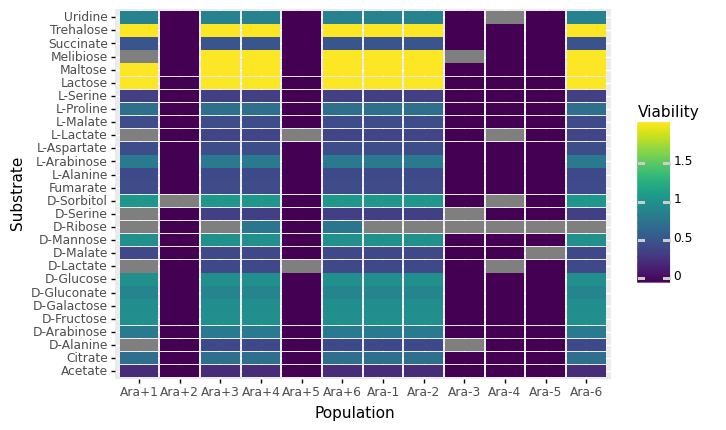

<ggplot: (8774133720209)>

In [33]:
(ggplot(REL606_model_viability_df, aes('Population','Substrate', fill='Viability'))
 + geom_tile(aes(width=0.95, height=0.95))
)